# Boston House Prices 예측 모델링

앞서 진행한 EDA 를 바탕으로 모델링에 활용될 변수를 선택하고, 선택된 변수를 이용하여 다양한 예측모델을 통해 최종적인 성능을 비교한다.

In [418]:
# import libraries
import numpy as np
from numpy import arange
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import scipy as sp
from scipy.special import boxcox1p
from scipy.stats import boxcox, boxcox_normmax, randint, uniform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer

## 1. 모델링 변수 선정 및 전처리 과정(preprocessing)

### EDA를 통한 변수 선택

앞서 진행한 EDA 의 과정을 통해서 종속변수인 MEDV 를 예측하는데 주요한 변수들을 선택한다.
 
 - MEDV와의 상관관계 분석 결과 연관성 높은 변수 : RM, LSTAT, PTRATIO 선택
 - CRIM의 경우 이 자체는 MEDV와 큰 관련성이 없는 것 같지만 EDA 결과 75 percentile 이상인 데이터에 대해 MEDV 의 경향성이 보이므로 모델에 긍정적 기여가 예상되므로 선택
 - CHAS의 경우 0/1 binary 값에 대해 MEDV의 차이가 눈에 띄지 않으므로 제외
 - ZN의 경우, 그룹화 분석 결과 MEDV와 관련성이 낮으므로 제외
 - TAX와 RAD 의 경우 상관성이 매우 높으므로 이 중 TAX만 선택
 - 나머지 변수 들인 INDUS, NOX, AGE, DIS의 경우 각 변수간의 상관성이 어느정도 있지만, 매우 높은편은 아니며, 각 데이터의 산포가 RAD, ZN 보다 크므로 예측 모델링 설명력에 기여할 수 있을것이라 판단하여 선택
 - B의 경우 MEDV와의 상관성이 제일 낮으며, 다른 변수들과의 관련성도 낮으므로 제외

최종적으로 RM,LSTAT, PTRATIO, CRIM, TAX, INDUS, NOX, AGE, DIS 를 예측모델링에 사용될 변수로 선택한다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003E38FB38>,
      dtype=object)

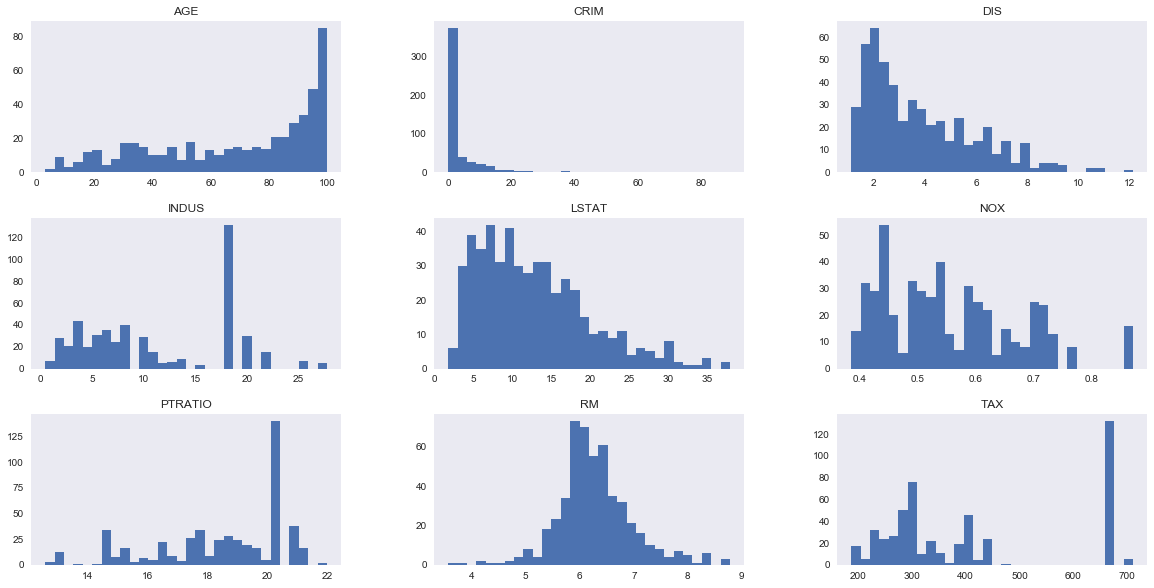

In [519]:
# 데이터 로드 및 변수 선택, 파생변수 생성
filename = ("dataset.csv")
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
dataset = pd.read_csv(filename, names=names)
feature = dataset.drop(['MEDV', 'ZN', 'CHAS', 'RAD', 'B'],  axis=1)

target = dataset['MEDV']

feature.hist(bins=30,figsize=(20,10), grid=False)

### Transform을 통해 Skewness 완화

Transform을 통해 skewness를 완화한 데이터의 분포를 재확인한다.
scipy 에서 지원하는 box-cox transformation을 이용하여 skewness를 완화하는 작업을 진행한다.
각 변수들의 skewness를 확인하고 여기서 절대값이 1보다 큰 변수를 추출한다. 해당 변수들을 boxcox transform 을 진행하며, 이때 파라미터로 사용되는 lambda는 optimal 한 box-cox 파라미터를 계산하는 boxcox_normmax 함수를 이용하여 선택한다.

CRIM    5.207652
DIS     1.008779
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000040682E10>,
      dtype=object)

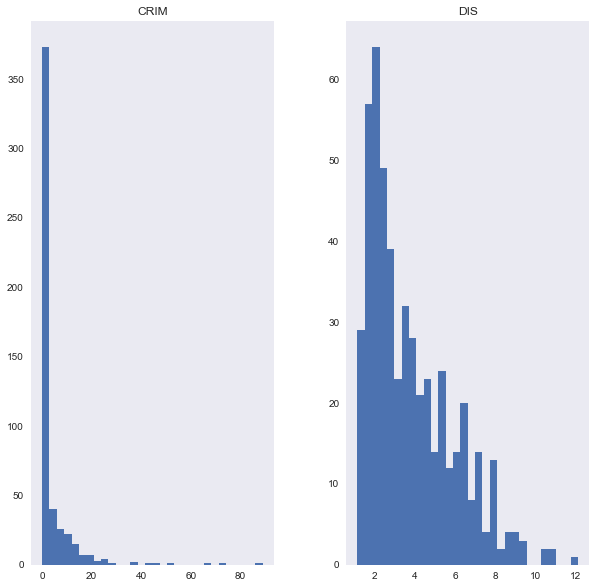

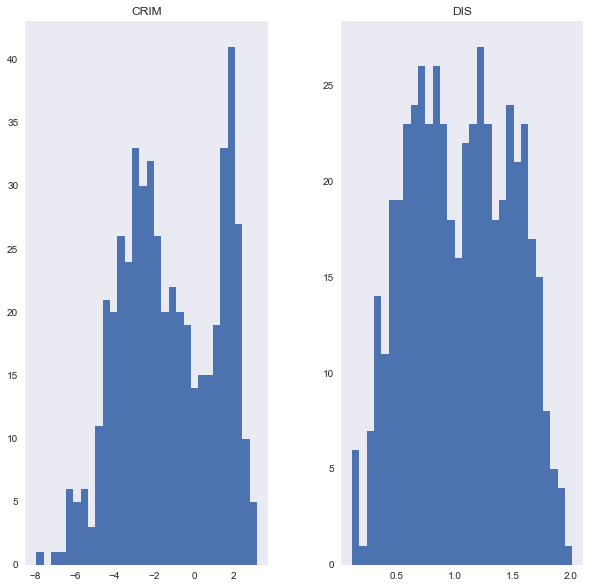

In [520]:
# 위에서 생성한 CRIM_binary는 string 타입이므로 skewness 를 확인 할 수 없으므로 이 변수를 제외함

available_col = []
for idx in feature.columns:
    if feature[idx].dtype != 'object':
        available_col.append(idx)

# Skewness 기준으로 정렬하여 절대값이 1 이상인 변수만 추출
skew_features = feature[available_col].apply(lambda x: sp.stats.skew(x)).sort_values(ascending=False)
high_skewed_features = skew_features[np.abs(skew_features) > 1.0]
print(high_skewed_features)

# Box-Cox 변환
skew_index = high_skewed_features.index
feature[skew_index].hist(bins=30, grid=False, figsize=(10,10), layout=(1,len(skew_index)))
for i in skew_index:
    feature[i] = boxcox(feature[i], boxcox_normmax(feature[i]))
feature[skew_index].hist(bins=30, grid=False, figsize=(10,10), layout=(1,len(skew_index)))


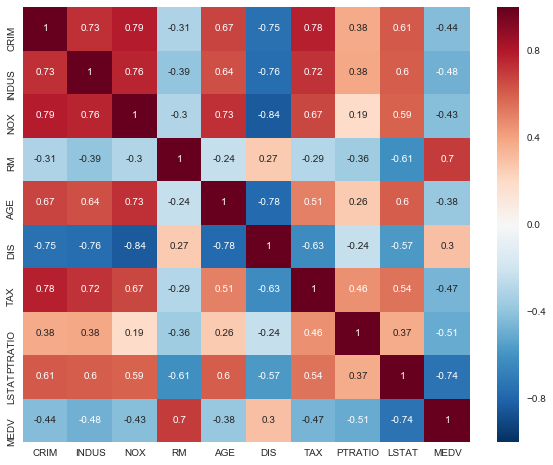

In [521]:
# Transform 된 변수에 대해서 다시 한번 상관성 확인
ax, fig = plt.subplots(figsize=(10,8))
feature['MEDV'] = target
sns.heatmap(feature.corr(), annot=True)
plt.show()
feature = feature.drop(['MEDV'], axis=1)

총 2개의 변수가 선택되어 box-cox 변환을 하였고, 위 아래로 데이터의 분포가 변화했음을 확인 할 수 있다. 변화된 변수를 이용하여 다시 한번 변수별 상관성을 살펴보면 몇몇 변수들의 상관성이 높아졌음을 볼 수 있으며, 예측모델링 시 다중공선성 문제가 발생할 수 있다.

## 2. 예측 모델링

### Training/Test 데이터 분할

최종적으로 선택된 11개의 변수를 이용하여 예측모델링을 진행한다.
우선적으로 Training 데이터와 Test 데이터를 분할한다. 데이터 분할은 8:2로 진행하며, 분할된 Test 데이터는 최종적으로 생성된 모델의 성능을 검증하는데 활용된다.


In [522]:
split_ratio= 0.2
seed = 1
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size=split_ratio, random_state=seed)
print(X_train.shape)
print(X_test.shape)

(404, 9)
(102, 9)


### 평가 척도 정의 

해당 문제의 평가 척도로는 RMSE(Root Mean Square Error) 를 이용한다. 이는 실제 Kaggle 에서 제시하는 평가척도이다.

In [523]:
def cal_rmse(y,y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Cross-validation을 통한 예측모형 성능 비교

우선 크게 Simple regression model과 ensemble model을 나눠서 모델 별 성능을 비교 분석하고, 최종적으로 활용할 모델을 선택한다. 모델 별 성능을 비교하기에 앞서 각 모델 별로 search 과정을 거쳐 최적의 hyper parameter 를 선택한 후, 각 모델이 최적화 된 상태에서 비교 분석을 진행한다. 

### Simple Regression Model

모델링을 진행할 때, Training 데이터에서 k-fold cross-validation 을 이용하여 모델의 평균적인 성능을 확인하며, hyper parameter tuning에도 활용된다. cross-validation에 사용될 fold의 수는 10개로 하며, 총 10번의 서로 다른 데이터에 대한 모델 학습 및 도출된 학습 결과의 평균을 통해 예측모형들의 성능을 비교한다.
첫번째 단계로, 예측 모델을 적용하기 이전에 데이터 표준화를 진행한다. 데이터마다 스케일이 다르기 때문에, 이를 보정하여 예측모델의 성능을 높이고자 한다. 이를 수행하기 위해 sklearn.preprocessing 에서 StandardScaler를 이용한다.
데이터표준화와 모델의 구성을 합치기 위해 파이프라인을 이용하여 구성한다.
모델 성능 평가 지표로는 RMSE를 사용한다.

In [524]:
# Gridsearch를 위해 rmse 를 평가척도로 따로 설정함. 기본적으로 gridsearchcv 는 score를 maximize하는 방향으로 학습되므로, 
# RMSE를 활용하기 위해서는 greater_is_better=False 로 설정한다.
# RMSE로 진행하더라도 내부적으로 score를 음수로 반환하므로 여기에 -를 곱해주어야한다.
scoring_fn = make_scorer(cal_rmse, greater_is_better=False)

본 분석에서는 모델의 hyper parameter tuning을 위해 Randomized Search와 Grid Search를 동시에 고려하는 search를 제시한다. 일반적으로 Grid search 혹은 Randomized search 중 하나를 사용하지만, 어떤 search가 더 좋은 성능을 나타내는지 모르기 때문에 두 가지 search를 모두 활용할 수 있도록 구성한다. 'fit_optimal_model' 라는 custom 함수를 통해 각 모델에서 성능이 높은 hyper parameter를 찾고, 최적의 hyper parameter로 조정된 모델로 pipeline을 구성한 결과를 얻는다.

In [525]:
def fit_optimal_model(model,params, x, y, n_folds, seed):
    # 설명 : Randomized search 와 Grid search를 동시에 활용해서 모델의 가장 좋은 parameter를 찾는다.
    
    # -----Input 설명-------- 
    # model은 name, pipeline 으로 받는다.
    # param은 model parameter set
    # x : X training set
    # y : Y training set
    # n_folds = k-fold의 n
    # seed : random seed
    # ----------------------- 
    
    # -----return 설명--------
    # best_model : Grid & Randomized search 결과 성능이 가장 좋은 모델을 반환(pipeline으로)
    # best_param : Grid & Randomized search 결과 성능이 가장 좋은 모델의 parameter set을 반환
    # best_search : Grid & Randomized search 결과 성능이 가장 좋은 search 의 결과물을 반환
    
    
    name, regressor = model
    [grid_param, random_param] = params
    # parameter가 굳이 random search가 필요하지 않은 경우(Gridsearch와 동일한 세팅일 때)엔 Grid search만 진행한다.
    if 'None' in list(random_param.keys()):
        do_random_search = False
    else:
        do_random_search = True   

    # Cross valiation을 위한 k=fold를 나눔
    kfold = KFold(n_splits=n_folds, random_state=seed)

    # 위의 설정을 이용해서 Grid search를 fit 한다.
    grid = GridSearchCV(estimator=regressor,param_grid=grid_param, cv=kfold, scoring=scoring_fn)
    grid_search = grid.fit(x, y)
    
    if do_random_search:
        # 위의 설정을 이용해서 Randomized search를 fit 한다.
        randomized_search_iter = 10
        random = RandomizedSearchCV(estimator=regressor, param_distributions=random_param, cv=kfold, scoring=scoring_fn, n_iter=randomized_search_iter)
        random_search = random.fit(x,y)
    
    # 두가기 search 결과 비교(RMSE 이므로 낮은 것이 좋음)
    if do_random_search:
        # search 결과 나오는 best_score는 RMSE로 설정했지만 내부적으로 음수로 계산되므로, -를 곱해준다.
        if grid_search.best_score_ * -1 <= random_search.best_score_* -1:
            best_param = grid_search.best_params_
            best_pipeline = grid_search.best_estimator_
            best_search = grid_search
        else:
            best_param = random_search.best_params_
            best_pipeline = random_search.best_estimator_
            best_search = random_search
    else:
            best_param = grid_search.best_params_
            best_pipeline = grid_search.best_estimator_
            best_search = grid_search

            
    return best_pipeline, best_param, best_search


우선적으로 먼저 사용할 예측모형들은 Lasso, Ridge, KNN, CART, SVR, LinearRegression 을 이용한다. 앞서 데이터 전처리를 통해 다중공선성 문제의 발생 가능성을 엿봤기 때문에, 이를 제어할 수 있는 예측모형인 Lasso, Ridge 의 결과를 통해 다중공선성 문제가 결정적으로 작용하는지 확인한다. 또한 전통적으로 많이 사용되는 KNN, CART, SVR, LinearRegression 도 비교한다. 
먼저 각 모델 별 hyper parameter 를 세팅한다.
- LinearRegression : 유일한 parameter인 fit_intercept
- LASSO : L2 regularizer의 가중치인 alpha(아주 작은 1e-4 ~ 1보다 큰 10까지 검증)
- RIDGE : L1 regularizer의 가중치인 alpha(아주 작은 1e-4 ~ 1보다 큰 10까지 검증)
- KNN : neighbor의 수 (3~10)
- CART : 트리의 max_depth, split을 하기 위한 최소한의 sample수인 min_samples_split 을 고려
    - max_depth의 경우 데이터 수가 적으므로 매우크지않는 선에서 설정 (6~10)
    - min_samples_split 또한 traning data가 cross-validation 시 400개 정도밖에 되지 않으므로, 작은 수치로 설정 (2~5)
- SVR : kernel 종류 (RBF, poly, sigmoid)

In [526]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
# Regression Model 별 파라미터 셋 정리
regression_models = [('LR',Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])), 
                     ('LASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])), 
                     ('RIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])), 
                     ('KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])), 
                     ('CART',Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])),
                     ('SVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())]))]
regression_params = {'LR' : [{"LR__fit_intercept": [True, False]}, {"None": [True, False]}],
                        'LASSO' : [{"LASSO__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]}, {"LASSO__alpha": uniform(1e-4, 10)}],
                        'RIDGE' : [{"RIDGE__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]}, {"RIDGE__alpha": uniform(1e-4, 10)}],
                        'KNN' : [{'KNN__n_neighbors': [3,4,5,6,7,8,9,10]}, {'KNN__n_neighbors': randint(3, 10)}],
                        'CART' : [{"CART__max_depth": range(6,10,1),"CART__min_samples_split": [2, 3, 4, 5]},
                                 {"CART__max_depth": randint(6,10),"CART__min_samples_split":randint(2, 5)}],
                        'SVR' : [{'SVR__kernel':['rbf', 'poly', 'sigmoid']},{'None':['rbf', 'poly', 'sigmoid']}]}

6개의 모델에서 현재 training data 에서 최적의 hyper parameter를 찾고, 찾은 최적 hyper parameter cross-validation 한 결과를 출력한다. 이를 box-plot을 통해 평균치와 분산을 확인한다.

LR: 4.890677 (0.776614)
{'LR__fit_intercept': True}
LASSO: 4.890638 (0.777008)
{'LASSO__alpha': 0.001}
RIDGE: 4.882848 (0.817652)
{'RIDGE__alpha': 8.27866010072957}
KNN: 3.713631 (0.817542)
{'KNN__n_neighbors': 4}
CART: 3.688043 (0.464919)
{'CART__max_depth': 6, 'CART__min_samples_split': 5}


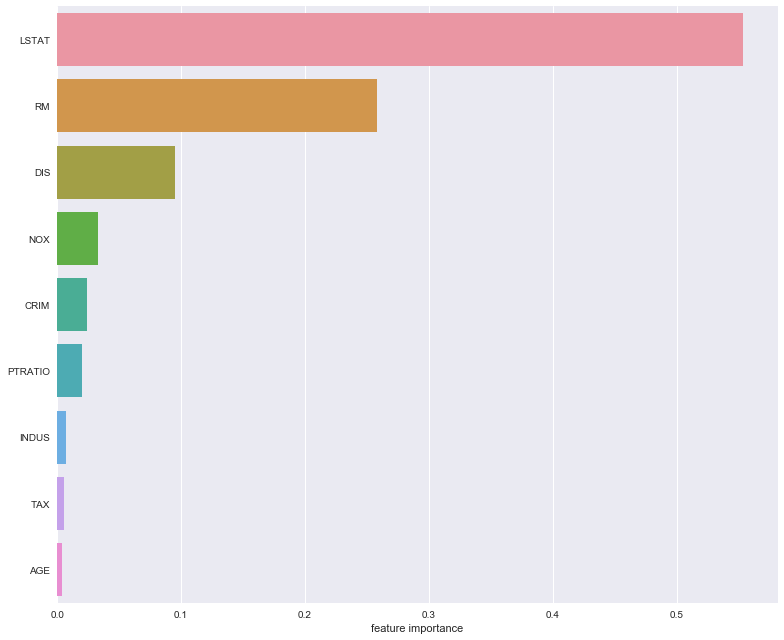

SVR: 4.839358 (1.457081)
{'SVR__kernel': 'rbf'}


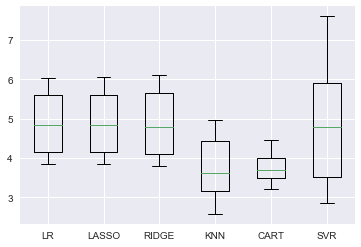

In [527]:
# 각 모델들을 cross-valiation 하여 그 평균적인 RMSE 값을 확인한다.

n_folds = 10
results = []
names = []
for reg_model in regression_models:
    name, model = reg_model
    kfold = KFold(n_splits=n_folds, random_state=seed)
    pipeline,best_param,_ = fit_optimal_model(reg_model, regression_params[name], X_train, Y_train,n_folds, seed)
    cv_results = -cross_val_score(pipeline, X_train, Y_train, cv=kfold, scoring=scoring_fn)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print(best_param)
    # 각 모델에서 사용된 변수들의 importance 확인
    if 'CART' in name:
        best_model = pipeline.named_steps[name]
        ranking = np.argsort(-best_model.feature_importances_)
        f, ax = plt.subplots(figsize=(11, 9))
        sns.barplot(x=best_model.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
        ax.set_xlabel("feature importance")
        plt.tight_layout()
        plt.show()
    
fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

box-plot의 결과를 살펴보면, LinearRegression과 LASSO, RIDGE 이 거의 비슷한 결과를 나타냄을 알 수 있다. LASSO와 RIDGE 는 각각 L1, L2 Reguralizer를 활용하여 overfitting을 피하고 다중공선성 문제를 완화시킨다고 알려져있다. 이전의 Box-Cox 변환을 통해 변화된 변수들의 상관성을 확인한 결과, 다중공선성 문제의 여지가 있다고 분석했는데 위의 모델 성능을 봤을 땐 크게 문제가 없는 것으로 보인다.
또한 간단한 6개의 모델 결과에서는 KNN과 CART가 가장 좋은 성능을 보임을 알 수 있다. KNN의 경우 n이 3~4에서 좋은 결과를 보이며, CART의 경우에서도 max_depth가 비교적 적은 수치(6 전후)에서 높은 성능을 보였다. 데이터의 수가 적고 단순하기 때문에 굳이 큰 사이즈의 Tree가 필요가 없을것으로 예상된다.
CART 의 경우는 변수 별 중요도를 추출할 수 있다. 이를 통해서 MEDV와 가장 상관성이 높은 LSTAT와 RM이 가장 큰 중요도를 차지하고, DIS, NOX가 다음이었다. CRIM의 경우 EDA에서 분석한 것처럼, 특정 영역에서 중요한 정보를 갖고 있으므로, 예측모델링에 기여했다고 분석 할 수 있다. 


### Ensemble Model

간단한 Regression 모델에 이어서 앙상블 모델을 위와 같이 동일하게 적용하여 모델의 성능들을 비교해본다. 여기서 사용할 앙상블 모델은 RandomForest, AdaBoost, XGboost, LightGBM 을 사용한다. 마찬가지로 각 모델들의 파라미터를 정리한다.
 - 공통 파라미터 : n_estimators 는 공통적으로 100~300으로 제한한다. step은 50으로 설정하고, randomized search에서는 100~300사이의 랜덤값을 이용한다. 또한 Randomforest를 제외하고 learning rate를 사용하는데 이는 1e-4 ~ 1e-1로 설정한다. 일반적으로 좋은 학습 성능을 이루기 위해서는 작은 learning rate를 추천하기 때문에, 작은 수치인 0.1보다 작은 수치로 실험
 
 - RandomForest : 앞서 DecisionTree에서 설정했던 parameter는 동일하게 설정하고, 추가로 bootstrap 옵션을 고려
 
 - Adaboost : loss를 고려
 
 - XGboost : max_depth는 위의 DecisionTree와 동일하게 구성하며, 추가로 min_child_weight, colsample_bytree, gamma를 고려
     - min_child_weight : chlid에서 필요한 모든 관측치에 대한 가중치의 최소 합에 대한 제약으로, 큰 값은 over-fitting을 방지
     - colsample_bytree : 개별 트리를 구성할 때 칼럼들이 랜덤하게 샘플되는 비율을 말하며, 일부 샘플링을 위해 0.8~1.0으로 설정
     - subsample : 개별 트리를 구성할 때 traning data가 랜덤으로 샘플되는 비율을 말하며, 0.8 ~ 1.0 으로 설정
     
 - LightGBM : 공통 parameter 이외에 num_leaves, boosting 옵션을 고려(num_leaves < 2^(max_depth) 이므로 이 제약을 만족하는 num_leaves를 찾기 위해 max_depth를 7로 고정)
     - num_leaves : 트리에 존재하는 총 leaves의 수로, 성능에 아주 중요한 역할을 함
     - boosting : boosting 방법중 선택하는 것으로, dart는 Dropouts meet Multiple Additive Regression Trees 를 의미함
     - LightGBM hyper parameter tuning의 경우 공식 document 에 recommended 된 옵션을 위주로 실험

In [528]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# Regression Model 별 파라미터 셋 정리
ensemble_models = [
                    ('RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])),
                   ('AB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])),
                   ('XG', Pipeline([('Scaler', StandardScaler()),('XG', XGBRegressor(n_jobs=-1))])),
                   ('LightGBM', Pipeline([('Scaler', StandardScaler()),('LightGBM', LGBMRegressor(max_depth=7))]))
                    ]

ensenble_params = { 
                    'XG' : [{"XG__n_estimators": range(100,300,50),"XG__max_depth": range(4,7,1),"XG__learning_rate": [1e-4, 1e-3, 1e-2, 1e-1], 'XG__min_child_weight': [1,3,5], 'XG__subsample': [0.8, 0.9, 1.0], 'XG__colsample_bytree': [0.8, 0.9, 1.0]},
                            {"XG__n_estimators": randint(100,300), "XG__max_depth": randint(4,7), "XG__learning_rate": uniform(1e-4, 1e-1), 'XG__min_child_weight': [1,3,5], 'XG__subsample':uniform(0.8 , 0.2),  'XG__colsample_bytree':uniform(0.8, 0.2)}],
                     'AB' : [{"AB__n_estimators": range(100,300,50),"AB__learning_rate": [1e-4, 1e-3, 1e-2, 1e-1],"AB__loss": ['linear','square','exponential']},
                            {"AB__n_estimators": randint(100,300),"AB__learning_rate": uniform(1e-4, 1e-1),"AB__loss": ['linear','square','exponential']}],
                    'RF' : [{"RF__n_estimators": range(100,300,50),"RF__max_depth": range(4,7,1),"RF__min_samples_split": [2,3,4,5],"RF__bootstrap": [True, False]},
                            {"RF__n_estimators": randint(100,300),"RF__max_depth": randint(4,7),"RF__min_samples_split":randint(2, 5),"RF__bootstrap": [True, False]}],
                   'LightGBM' : [{"LightGBM__n_estimators": range(100,300,50),"LightGBM__num_leaves": range(40,80,10), "LightGBM__learning_rate": [1e-4, 1e-3, 1e-2, 1e-1],"LightGBM__boosting" : ['gbdt', 'dart']},
                            {"LightGBM__n_estimators": randint(100,300), "LightGBM__num_leaves": randint(40, 80), "LightGBM__learning_rate": uniform(1e-4, 1e-1), "LightGBM__boosting" : ['gbdt', 'dart'] }]
                  }

RF: 3.265418 (0.504214)
{'RF__bootstrap': True, 'RF__max_depth': 6, 'RF__min_samples_split': 2, 'RF__n_estimators': 100}


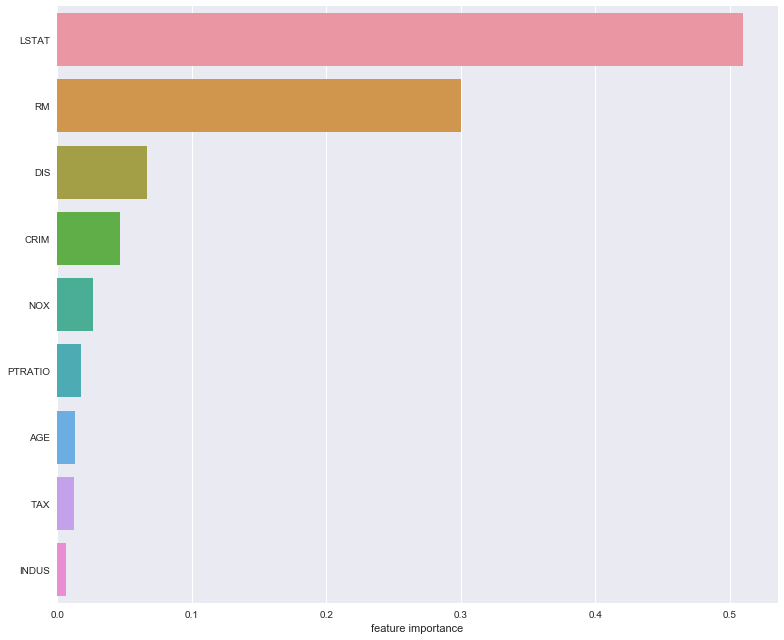

AB: 3.607081 (0.419985)
{'AB__learning_rate': 0.1, 'AB__loss': 'linear', 'AB__n_estimators': 100}


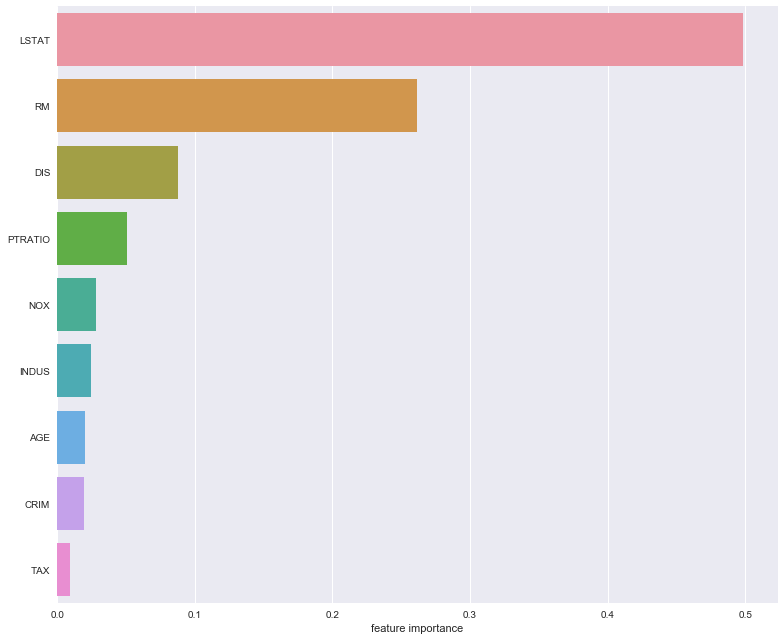

XG: 2.879215 (0.402816)
{'XG__colsample_bytree': 0.8, 'XG__learning_rate': 0.1, 'XG__max_depth': 4, 'XG__min_child_weight': 3, 'XG__n_estimators': 150, 'XG__subsample': 0.9}


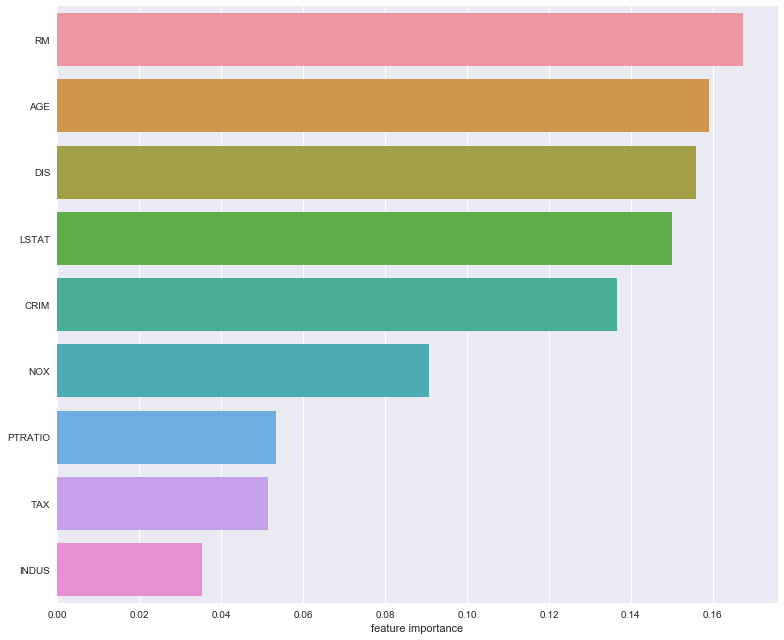

LightGBM: 3.200663 (0.580637)
{'LightGBM__boosting': 'gbdt', 'LightGBM__learning_rate': 0.1, 'LightGBM__n_estimators': 200, 'LightGBM__num_leaves': 40}


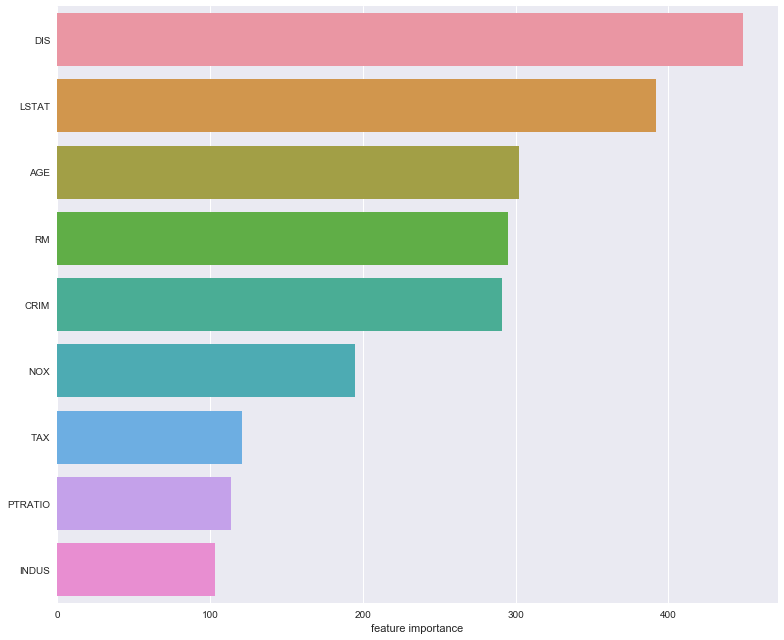

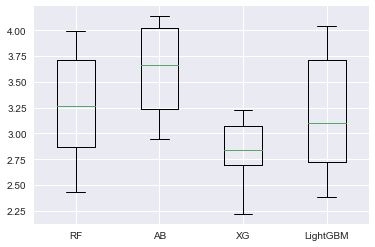

In [529]:
# 각 모델들을 cross-valiation 하여 그 평균적인 RMSE 값을 확인한다.

n_folds = 10
results = []
names = []
for ens_model in ensemble_models:
    name, model = ens_model
    kfold = KFold(n_splits=n_folds, random_state=seed)
    pipeline,best_param,_ = fit_optimal_model(ens_model, ensenble_params[name], X_train, Y_train,n_folds, seed)
    cv_results = -cross_val_score(pipeline, X_train, Y_train, cv=kfold, scoring=scoring_fn)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print(best_param)
    # 각 모델에서 사용된 변수들의 importance 확인
    best_model = pipeline.named_steps[name]
    ranking = np.argsort(-best_model.feature_importances_)
    f, ax = plt.subplots(figsize=(11, 9))
    sns.barplot(x=best_model.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
    ax.set_xlabel("feature importance")
    plt.tight_layout()
    plt.show()
    
fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

앙상블 모델의 경우 위에서 실험한 간단한 regression 모델에 비해 전체적으로 더 높은 성능을 나타낸다. CART가 가장 높은 성능을 나타냈지만 Adaboost가 더 높은 성능을 보인다. 앙상블 모델 중 가장 좋은 성능을 보이는 모델은 XGBoost로 학습시간에서는 상당한 시간이 걸리지만 좋은 성능을 보임을 알 수 있다. 또한 이전의 CART의 결과와 비슷하게 max_depth는 모두 6정도로 깊은 트리는 필요하지 않음을 알 수 있다.

각 앙상블 모델 별로 feature importance를 살펴보면, 종속변수와 상관성이 높은 LSTAT와 RM은 항상 상위에 위치해있음을 알 수 있다. 상대적으로 성능이 좋은 XGboost와 LightGBM의 경우는 상위 5개 변수가 차이가 조금씩 나지만 크게 영향력을 미침을 알 수 있다. XGboost와 LightGBM 이 다른 두 모델과 명확이 차이 나는 변수는 AGE, DIS, CRIM으로 기존의 EDA 분석에서 느꼈던 중요도보다 더 중요한 변수임을 확인할 수 있다. 

### Final Model Training using StackingCVRegressor

최종적으로 mlxtend 라이브러리의 StackingCVRegressor 라는 앙상블 방식을 이용하여 최종 모델을 학습한다.
StackingCVRegressor 이란 앙상블 방식의 meta-regressor로, 총 2가지의 레벨로 구분된다. 
첫번째 레벨에서는 일반적인 regressor(base regressor)를 이용하여 Training Data를 K-fold로 분할하여 K-1 로 학습을 하고 남은 하나의 셋에 대해 예측한 결과들을 두번째 레벨에서 meta-regressor가 meta-feature로 활용하여 최종적으로 예측모형을 구성하게 된다. 

다음은 StackingCVRegressor 학습되는 절차를 pseudo-code를 의미한다.
    
    # Choose base regressor
    For all regressor r:
        best_models.append(fit_optimal_model(r)) -> Custom function
    sort best_models by performance 
    choose n regressors as base regressor
    
    # StackingCVRegressor Training Procedure
    For each base regressor b:
        For iter in cross-validation:
            fit b to training k-1 folds
            predict k-th fold(hold-out fold) using b (prediction result = meta-features)
    use meta-features(optionally with original data) to fit meta-regressor
    fit each base regressor to the original data

본 분석에서 StackingCVRegressor를 활용한 이유는 다음과 같다. 
- 일반 average ensemble 방식은 각 모델의 예측치를 linear combination으로 결합하여 최종 결과를 내는데, 이에 비해 meta-regressor를 이용함으로써 더 좋은 성능을 낼 것이란 기대
- Meta-regressor 가 각 base model의 예측치를 input으로 받으면서 기존 base model이 설명하지 못하는 잔차를 한번 더 학습한다는 개념
- 여러 개의 model을 base regressor로 이용하면서 하나의 모델로 fine-tuning 한 결과보다 Test 데이터에 대해 robust한 결과를 도출할 것이라는 기대


In [530]:
from mlxtend.regressor import StackingCVRegressor

def stack_train(X, Y, models, params, n_folds, seed, n_choice_model = 3):
    
    # 설명 : 위에서 정의한 fit_optimal_model 을 이용하여 성능이 높은 n_choice_model 를 선택하여 이를 base regressor로 활용하고, 
    #         meta-regressor로 RandomForest를 활용하여 Stacked Regressor 를 학습한다. fit_optimal_model을 통해 최적의 base regressor 
    #        모델을 찾으면 해당 base regressor는 고정하고, meta-regressor를 grid search로 hyper parameter tuning을 진행한다.
    # 
    # -----Input 설명-------- 
    # x : X training set
    # y : Y training set
    # model은 name, pipeline 으로 받는다.
    # param은 model parameter set
    # n_folds = k-fold의 n
    # seed : random seed
    # n_choice_model : Base regressor로 활용할 모델의 수
    # ----------------------- 
    
    # -----return 설명--------
    # best_model : Grid search 결과 성능이 가장 좋은 StackingCVRegressor 을 반환
    # selected_model : fit_optimal_model 결과 성능이 높아서 base regressor로 선택된 모델의 이름을 반환
    # best_base_model : 선택된 base regressor 중 가장 성능이 좋은 regressor 반환

    # 현재 traning data에 대해 fit_optimal_model를 통해 각 모델의 최적의 hyper parameter 을 찾는다.
    best_models = {}
    best_models_pipeline = {}

    for model in models:
        name, model_object = model
        kfold = KFold(n_splits=n_folds, random_state=seed)
        pipeline, best_param, best_search = fit_optimal_model(model, params[name], X, Y, n_folds, seed)
        best_models[name] = -best_search.best_score_
        best_models_pipeline[name] = pipeline
    
    # 반환된 최적의 모델 중 성능이 높은 순서로 n_choice_model 를 선택한다. 
    sorted_best_models = sorted(best_models.items(), key=lambda x: x[1])
    regressor = []
    selected_model = []

    for idx in range(n_choice_model):
        model_name, best_score  = sorted_best_models[idx]
        model_pipe = best_models_pipeline[model_name]
        if idx == 0:
            best_base_model = model_pipe
        regressor.append(model_pipe)
        selected_model.append(model_name)
        print(model_name + ' is chosen with RMSE : %.3f' % best_score)
    
    # meta-regressor 는 RandomForestRegressor 를 이용하고, Grid search를 통해 최적의 meta-regressor를 찾는다.
    # 여기서는 위와는 달리 고려하는 hyper-parameter 를 n_estimators와 max_depth만 고려한다. 
    meta_regressor = Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])
    stack = StackingCVRegressor(regressors=regressor, meta_regressor=meta_regressor, use_features_in_secondary=True)
    meta_regressor_params = {"meta-pipeline__RF__n_estimators": range(100,300,50),"meta-pipeline__RF__max_depth": range(4,7,1)}
    kfold = KFold(n_splits=n_folds, random_state=seed)
    grid = GridSearchCV(estimator=stack, param_grid= meta_regressor_params, cv=kfold, scoring = scoring_fn)
    grid_search = grid.fit(np.array(X), np.array(Y))
    print("Best: %f using %s" % (-grid_search.best_score_, grid_search.best_params_))
    best_model = grid_search.best_estimator_
    
    return best_model, selected_model, best_base_model

# stack_train 이후 반환된 best_model을 이용하여 Test data에 대해 predict를 진행
def stack_predict(best_model, X_test):
    return best_model.predict(np.array(X_test))

### Model Prediction and Evaluation

최종적으로 위에서 실험한 간단한 regression 모델과 ensemble 모델을 합쳐서 StackingCVRegressor 를 학습한다. 학습된 StackingCVRegressor를 이용하여 이전에 분할해 놓은 X_test 데이터로 결과를 얻는다. 최종 결과는 RMSE로 계산된다.

### Final Model Traning

In [472]:
# 위의 제시한 regression model 과 ensemble model을 모두 합쳐 stack traning 에 적용한다.
models = regression_models + ensemble_models
params = {**regression_params, **ensenble_params}
stacked_model, _ , best_base_model= stack_train(X_train, Y_train, models, params, n_folds, seed)


XG is chosen with RMSE : 2.896
LightGBM is chosen with RMSE : 3.195
RF is chosen with RMSE : 3.198
Best: 2.970357 using {'meta-pipeline__RF__max_depth': 5, 'meta-pipeline__RF__n_estimators': 150}
2.7904619549647984
2.892899875597986


### Final Model Evaluation

In [ ]:
# 학습된 모델로 prediction
y_pred = stack_predict(stacked_model, X_test)
y_pred_basemodel = best_base_model.predict(X_test)
print("StackCVRegressor Test RMSE : %f" % cal_rmse(Y_test, y_pred)) 
print("Best base model Test RMSE : %f" % cal_rmse(Y_test, y_pred_basemodel))

사용된 base model은 hyper parameter tuning 결과 XGboost, LightGBM, RandomForest가 선택되었고, 이를 이용하여 최종적으로 학습된 StackingCVRegressor은 RMSE가 2.97로 XGboost 보다 낮은 성능이 도출되었다. 하지만 Test 데이터에 대해서는 XGboost보다 높은 성능을 보임을 확인 할 수 있다.

### Training/Test 데이터 분할 및 Model Traning/Evaluation 반복(with Multiple random seed)

또한 학습하는 프로세스를 다 함수로 구성해놓았기 때문에, Training/Test 데이터를 여러 번 split하면서 모델의 평균적인 성능을 검증할 수 있다. 총 5번의 random seed를 통해서 Training/Test를 구분하고 학습과정을 거쳐 최종 결과를 출력한다.

XG is chosen with RMSE : 2.613
LightGBM is chosen with RMSE : 2.845
RF is chosen with RMSE : 3.207
Best: 2.708687 using {'meta-pipeline__RF__max_depth': 4, 'meta-pipeline__RF__n_estimators': 200}
selected model list :  ['XG', 'LightGBM', 'RF']
StackCVRegressor Test RMSE : 4.975859
Best base model Test RMSE : 4.918751
---------------------------------------------------------------------
XG is chosen with RMSE : 2.882
LightGBM is chosen with RMSE : 3.193
RF is chosen with RMSE : 3.206
Best: 2.966476 using {'meta-pipeline__RF__max_depth': 4, 'meta-pipeline__RF__n_estimators': 250}
selected model list :  ['XG', 'LightGBM', 'RF']
StackCVRegressor Test RMSE : 3.008291
Best base model Test RMSE : 2.687349
---------------------------------------------------------------------
XG is chosen with RMSE : 2.927
RF is chosen with RMSE : 3.259
LightGBM is chosen with RMSE : 3.270
Best: 2.895076 using {'meta-pipeline__RF__max_depth': 6, 'meta-pipeline__RF__n_estimators': 150}
selected model list :  ['X

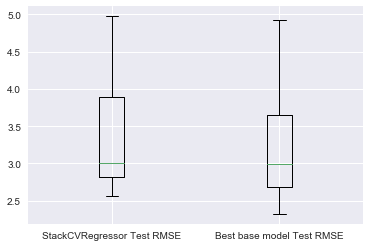

In [533]:
split_ratio= 0.2
random_seed = [0,1,2,3,4]
models = regression_models + ensemble_models
params = {**regression_params, **ensenble_params}
n_folds = 10
names = ['StackCVRegressor Test RMSE','Best base model Test RMSE']
y_pred_list =[]
y_pred_basemodel_list =[]

for seed in random_seed:
    X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size=split_ratio, random_state=seed)
    stacked_model, selected_model, best_base_model= stack_train(X_train, Y_train, models, params, n_folds, seed)
    y_pred = stack_predict(stacked_model, X_test)
    y_pred_basemodel = best_base_model.predict(X_test)
    y_pred_list.append(cal_rmse(Y_test, y_pred))
    y_pred_basemodel_list.append(cal_rmse(Y_test, y_pred_basemodel))
    print("selected model list : ", selected_model)
    print("StackCVRegressor Test RMSE : %f" % cal_rmse(Y_test, y_pred)) 
    print("Best base model Test RMSE : %f" % cal_rmse(Y_test, y_pred_basemodel))
    print("---------------------------------------------------------------------")
    
fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.boxplot([y_pred_list, y_pred_basemodel_list])
ax.set_xticklabels(names)
pyplot.show()

5번 모두 XGboost가 가장 좋은 base model로 선택되었다. 5번의 서로 다른 학습 결과, 한번을 제외하고 XGboost의 성능이 높았다. 하지만 위에서 StackCVRegressor 의 robust한 결과를 예상하므로 최종적으로는 StackCVRegressor 를 선택하여 예측치를 계산한다.